In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simps

%matplotlib inline

In [2]:
inputfile = '../input_bpass_z002_sin_imf135_300'
masses = []
weights = []
f = open(inputfile,'r')
tot_imf = f.readline()
while True:
    filename = f.readline()
    if not filename:
        break
    mass = filename.split('-')[-1]
    masses.append(float(mass))
    imf_line = f.readline()
    imf_weight = imf_line.split()[0]
    weights.append(float(imf_weight))
f.close()
masses = np.flip(masses)
weights = np.flip(weights)

[None, None]

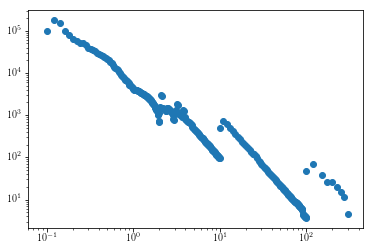

In [4]:
plt.scatter(masses, weights)
plt.gca().set(xscale='log',yscale='log')

The IMF looks like:

$\Phi(M) = AM^{-\alpha}$

If the slope changes at $M_*$ from $\alpha_1$ (low mass slope) to $\alpha_2$ (high mass slope), we require the IMF the yield the same value given both slopes, requiring two different normalizations. If we know the high mass slope (e.g., Salpeter 2.35 IMF) and normalization:

$A_1M_*^{-\alpha_1} = A_2M_*^{-\alpha_2}$

$A_1 = A_2 M_*^{\alpha_1 - \alpha_2}$

In [5]:
def IMF(mass,hi_mass_normalization=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    lo_mass_normalization = hi_mass_normalization*m_star**(lo_mass_slope-hi_mass_slope)
    if hasattr(mass,'__len__'):
        out = []
        for m in mass:
            if (m < lo_mass_cut) or (m > hi_mass_cut):
                out.append(0)
            elif (m <= m_star):
                out.append(lo_mass_normalization*m**-lo_mass_slope)
            else:
                out.append(hi_mass_normalization*m**-hi_mass_slope)
        return out
    else:
        if (mass < lo_mass_cut) or (mass > hi_mass_cut):
            return 0
        elif (mass <= m_star):
            return lo_mass_normalization*mass**-lo_mass_slope
        else:
            return hi_mass_normalization*mass**-hi_mass_slope

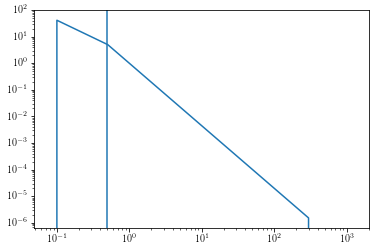

In [6]:
#is the function working correctly?
test_masses = np.logspace(-1.1,3.1,1000)
test_imf = IMF(test_masses)
plt.loglog(test_masses, test_imf)
plt.axvline(x=0.5)

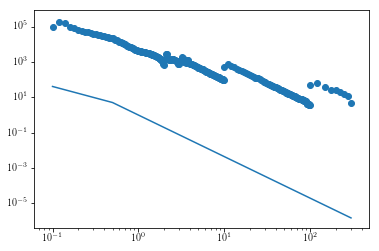

In [7]:
#are the weights just the raw IMF? (no)
plt.loglog(masses,IMF(masses))
plt.scatter(masses,weights)

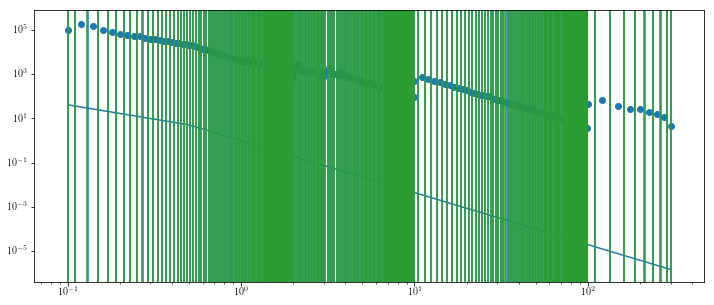

In [8]:
#Because this is discretized, we need to decide on bin edges. Two options: have bin edges
#evenly spaced between masses on a linear scale, or evenly spaced on a log scale 
fig = plt.figure(figsize=(12,5))
linear_bin_edges = [masses[0]]
log_bin_edges = [masses[0]]
for i,m in enumerate(masses):
    if i == 0:
        pass
    else:
        average = 0.5*(masses[i-1] + m)
        linear_bin_edges.append(average)
        logarithmic_average = np.power(masses[i-1]*m,0.5)
        log_bin_edges.append(logarithmic_average)
        
linear_bin_edges.append(300.0)
log_bin_edges.append(300.0)
linear_bin_edges = np.array(linear_bin_edges)
log_bin_edges = np.array(log_bin_edges)
plt.loglog(masses,IMF(masses))
plt.scatter(masses,weights)
for e in linear_bin_edges:
    plt.axvline(x=e)
for e in log_bin_edges:
    plt.axvline(x=e,c='C2')

[None, None]

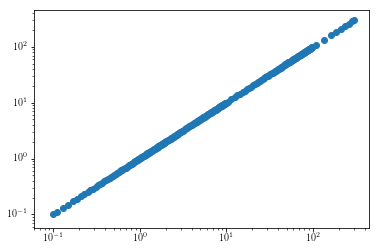

In [11]:
plt.scatter(linear_bin_edges,log_bin_edges)
plt.gca().set(xscale='log',yscale='log')

First let's figure out the total number of stars formed. In BPASS, that's just the sum of the weights, $N_*$. For our IMF, with lower limit $M_l$, upper limit $M_u$, and threshold mass $M_*$, that's going to be the integral

$N = \int_{M_l}^{M_u}\Phi(M)dM = \int_{M_l}^{M_*}A_1M^{-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{-\alpha_2}dM$

We can substitute in for the lower mass normalization:

$N = \int_{0.1}^{M_*}A_2M_*^{\alpha_1-\alpha_2}M^{-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{-\alpha_2}dM$

Solving directly:

$N = A_2 \bigg[\frac{M_*^{\alpha_1-\alpha_2}M^{1-\alpha_1}}{1-\alpha_1}\Big|_{M_l}^{M_*} + \frac{M^{1-\alpha_2}}{1-\alpha_2}\Big|_{M_*}^{M_u}\bigg]$ 

$N = A_2\bigg[\frac{M_*^{1-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{1-\alpha_1}}{1-\alpha_1}+ \frac{M_u^{1-\alpha_2}-M_*^{1-\alpha_2}}{1-\alpha_2}\bigg]$

So, if we want the weights to work out identically, we can set $N=N_*$, so

$A_2 = \frac{N_*}{\frac{M_*^{1-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{1-\alpha_1}}{1-\alpha_1}+ \frac{M_u^{1-\alpha_2}-M_*^{1-\alpha_2}}{1-\alpha_2}}$

In [12]:
#writing a function to implement this
def IMF_known_stars(mass,N_stars=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    
    numerator = N_stars
    
    denom1_num = np.power(m_star,1.0-hi_mass_slope)-np.power(m_star,lo_mass_slope-hi_mass_slope)*np.power(lo_mass_cut,1.0-lo_mass_slope)
    denom1_den = 1.0 - lo_mass_slope
    denom1 = denom1_num/denom1_den
    
    denom2_num = np.power(hi_mass_cut,1.0-hi_mass_slope) - np.power(m_star,1.0-hi_mass_slope)
    denom2_den = 1.0-hi_mass_slope
    denom2 = denom2_num/denom2_den
    
    denomenator = denom1 + denom2
    
    hi_mass_normalization = numerator/denomenator

    
    return IMF(mass,hi_mass_normalization=hi_mass_normalization,lo_mass_slope=lo_mass_slope,
              hi_mass_slope=hi_mass_slope,m_star=m_star,lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut)

Alternately, maybe we know the Mass of the population, $M_{tot}$. The total mass is

$M = \int_{M_l}^{M_u}M\Phi(M)dM = \int_{M_l}^{M_*}A_1M^{1-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{1-\alpha_2}dM$

We can substitute in for the lower mass normalization:

$M = \int_{0.1}^{M_*}A_2M_*^{\alpha_1-\alpha_2}M^{1-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{1-\alpha_2}dM$

Solving directly:

$M = A_2 \bigg[\frac{M_*^{\alpha_1-\alpha_2}M^{2-\alpha_1}}{2-\alpha_1}\Big|_{M_l}^{M_*} + \frac{M^{2-\alpha_2}}{2-\alpha_2}\Big|_{M_*}^{M_u}\bigg]$ 

$M = A_2\bigg[\frac{M_*^{2-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{2-\alpha_1}}{2-\alpha_1}+ \frac{M_u^{2-\alpha_2}-M_*^{2-\alpha_2}}{2-\alpha_2}\bigg]$

So, if we want the weights to work out identically, we can set $M=M_{tot}$, so

$A_2 = \frac{M_{tot}}{\frac{M_*^{2-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{2-\alpha_1}}{2-\alpha_1}+ \frac{M_u^{2-\alpha_2}-M_*^{2-\alpha_2}}{2-\alpha_2}}$

In [39]:
#writing a function to implement this
def IMF_known_mass(mass,M_tot=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    
    numerator = M_tot
    
    denom1_num = np.power(m_star,2.0-hi_mass_slope)-np.power(m_star,lo_mass_slope-hi_mass_slope)*np.power(lo_mass_cut,2.0-lo_mass_slope)
    denom1_den = 2.0 - lo_mass_slope
    denom1 = denom1_num/denom1_den
    
    denom2_num = np.power(hi_mass_cut,2.0-hi_mass_slope) - np.power(m_star,2.0-hi_mass_slope)
    denom2_den = 2.0-hi_mass_slope
    denom2 = denom2_num/denom2_den
    
    denomenator = denom1 + denom2
    
    hi_mass_normalization = numerator/denomenator

    
    return IMF(mass,hi_mass_normalization=hi_mass_normalization,lo_mass_slope=lo_mass_slope,
              hi_mass_slope=hi_mass_slope,m_star=m_star,lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut)

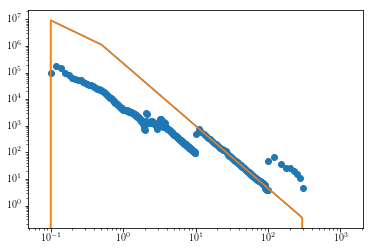

In [40]:
test_masses = np.logspace(-1.1,3.1,1000)
test_imf = IMF_known_stars(test_masses,np.sum(weights))
test_imf2 = IMF_known_mass(test_masses,1e6)
plt.loglog(test_masses,test_imf)
plt.loglog(test_masses,test_imf2)
plt.scatter(masses,weights)

So it's clear we're going to need to perform the integral. Regardless of the bins we choose, the number of stars with mass between $m_1$ and $m_2$ is

$N(m_1,m_2) = \int_{m_1}^{m_2}\Phi(M)dM$

In [41]:
#Now, let's try integrating the IMF over a bin between left and right. Has to handle low/hi
#mass cases, and bins that cross the knee mass

def integrate_IMF_known_stars(left,right,N_stars=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    
    assert right > left
    
    numerator = N_stars
    
    denom1_num = np.power(m_star,1.0-hi_mass_slope)-np.power(m_star,lo_mass_slope-hi_mass_slope)*np.power(lo_mass_cut,1.0-lo_mass_slope)
    denom1_den = 1.0 - lo_mass_slope
    denom1 = denom1_num/denom1_den
    
    denom2_num = np.power(hi_mass_cut,1.0-hi_mass_slope) - np.power(m_star,1.0-hi_mass_slope)
    denom2_den = 1.0-hi_mass_slope
    denom2 = denom2_num/denom2_den
    
    denomenator = denom1 + denom2
    
    hi_mass_normalization = numerator/denomenator
    
    #trim bin to the mass threshold
    if left < lo_mass_cut:
        left = lo_mass_cut
    
    if right > hi_mass_cut:
        right = hi_mass_cut
    
    if right <= m_star:
        new_slope = 1.0 - lo_mass_slope
        norm = hi_mass_normalization * np.power(m_star,lo_mass_slope-hi_mass_slope) / new_slope
        return norm * (np.power(right,new_slope)-np.power(left,new_slope))
    
    elif left >= m_star:
        new_slope = 1.0 - hi_mass_slope
        norm = hi_mass_normalization / new_slope
        return norm * (np.power(right,new_slope)-np.power(left,new_slope))

    
    else: 
        return (integrate_IMF_known_stars(left=left,right=m_star,N_stars=N_stars,
                                         lo_mass_slope=lo_mass_slope,
                                         hi_mass_slope=hi_mass_slope,m_star=m_star,
                                         lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut) +
                integrate_IMF_known_stars(left=m_star,right=right,N_stars=N_stars,
                                         lo_mass_slope=lo_mass_slope,
                                         hi_mass_slope=hi_mass_slope,m_star=m_star,
                                         lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut))

In [42]:
#Same but in case where we know the mass of the cluster

def integrate_IMF_known_mass(left,right,M_tot=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    
    assert right > left
    
    numerator = M_tot
    
    denom1_num = np.power(m_star,2.0-hi_mass_slope)-np.power(m_star,lo_mass_slope-hi_mass_slope)*np.power(lo_mass_cut,2.0-lo_mass_slope)
    denom1_den = 2.0 - lo_mass_slope
    denom1 = denom1_num/denom1_den
    
    denom2_num = np.power(hi_mass_cut,2.0-hi_mass_slope) - np.power(m_star,2.0-hi_mass_slope)
    denom2_den = 2.0-hi_mass_slope
    denom2 = denom2_num/denom2_den
    
    denomenator = denom1 + denom2
    
    hi_mass_normalization = numerator/denomenator
    
    #trim bin to the mass threshold
    if left < lo_mass_cut:
        left = lo_mass_cut
    
    if right > hi_mass_cut:
        right = hi_mass_cut
    
    if right <= m_star:
        new_slope = 1.0 - lo_mass_slope
        norm = hi_mass_normalization * np.power(m_star,lo_mass_slope-hi_mass_slope) / new_slope
        return norm * (np.power(right,new_slope)-np.power(left,new_slope))
    
    elif left >= m_star:
        new_slope = 1.0 - hi_mass_slope
        norm = hi_mass_normalization / new_slope
        return norm * (np.power(right,new_slope)-np.power(left,new_slope))

    
    else: 
        return (integrate_IMF_known_mass(left=left,right=m_star,M_tot=M_tot,
                                         lo_mass_slope=lo_mass_slope,
                                         hi_mass_slope=hi_mass_slope,m_star=m_star,
                                         lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut) +
                integrate_IMF_known_mass(left=m_star,right=right,M_tot=M_tot,
                                         lo_mass_slope=lo_mass_slope,
                                         hi_mass_slope=hi_mass_slope,m_star=m_star,
                                         lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut))

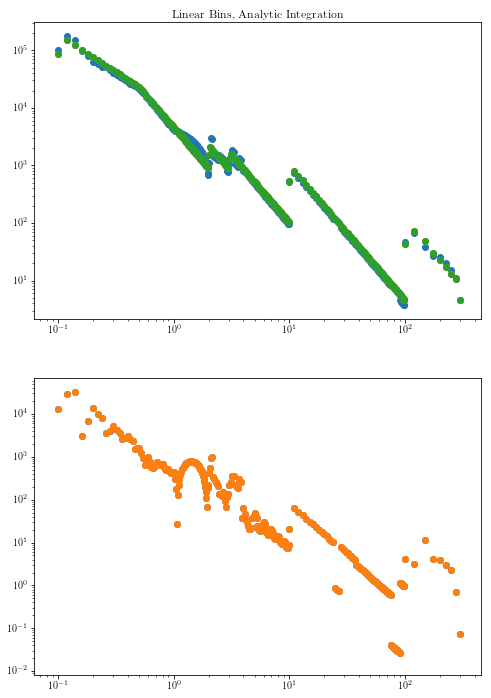

In [52]:
#With that done, let's try integrating over the bins
fig, ax = plt.subplots(2,figsize=(8,12))
test_weights = []
test_weights2 = []
for i,m in enumerate(masses):
    left = linear_bin_edges[i]
    right = linear_bin_edges[i+1]
    test_weight = integrate_IMF_known_stars(left,right,N_stars=np.sum(weights))
    test_weight2 = integrate_IMF_known_mass(left,right,M_tot=1.0e6)
    test_weights.append(test_weight)
    test_weights2.append(test_weight)
ax[0].scatter(masses,weights)
ax[0].scatter(masses,test_weights)
ax[0].scatter(masses,test_weights2)
ax[0].set(xscale='log',yscale='log',title='Linear Bins, Analytic Integration')
ax[1].scatter(masses,np.abs(np.array(test_weights)-np.array(weights)))
ax[1].scatter(masses,np.abs(np.array(test_weights2)-np.array(weights)))
ax[1].set(xscale='log',yscale='log');

In [47]:
np.sum(weights) == np.sum(test_weights)

True

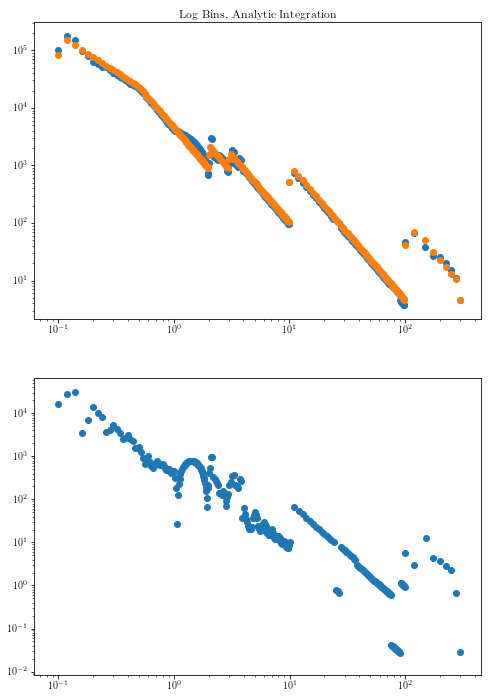

In [34]:
#With that done, let's try integrating over the bins, log style
fig, ax = plt.subplots(2,figsize=(8,12))
test_weights = []
for i,m in enumerate(masses):
    left = log_bin_edges[i]
    right = log_bin_edges[i+1]
    test_weight = integrate_IMF_known_stars(left,right,N_stars=np.sum(weights))
    test_weights.append(test_weight)
ax[0].scatter(masses,weights)
ax[0].scatter(masses,test_weights)
ax[0].set(xscale='log',yscale='log',title='Log Bins, Analytic Integration')
ax[1].scatter(masses,np.abs(np.array(test_weights)-np.array(weights)))
ax[1].set(xscale='log',yscale='log');

[None, None]

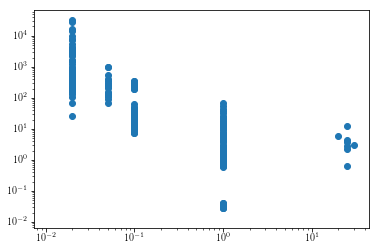

In [36]:
deltamass = np.diff(masses)
plt.scatter(deltamass,np.abs(np.array(test_weights)[:-1]-np.array(weights)[:-1]))
plt.gca().set(xscale='log',yscale='log')